<a href="https://colab.research.google.com/github/bhagyapatel/Data-Scientest-/blob/main/loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DESCRIPTION

For safe and secure lending experience, it's important to analyze the past data. In this project, you have to build a deep learning model to predict the chance of default for future loans using the historical data. As you will see, this dataset is highly imbalanced and includes a lot of features that make this problem more challenging.

Objective: Create a model that predicts whether or not an applicant will be able to repay a loan using historical data.

Domain: Finance

  Load the dataset that is given to you

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':'1HtcH7TNQjBrM0EpNDGkQbAOD2g2J5DYC'})
df = downloaded.GetContentFile("loan_data.csv") 
df = pd.read_csv("loan_data.csv")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Check for null values in the dataset

In [5]:
df.isna().sum()[1:10]
df.select_dtypes(include=['object']).isnull().sum()
str_col = ["NAME_TYPE_SUITE", "OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"]
df[str_col]=df[str_col].fillna(df.mode().iloc[0])
df[str_col].head(2)

,NAME_TYPE_SUITE,OCCUPATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Unaccompanied,Laborers,reg oper account,block of flats,"Stone, brick",No
1,Family,Core staff,reg oper account,block of flats,Block,No


In [6]:
df1 = df.drop(df.columns[44:86], axis=1) 
df1.shape


(307511, 80)

In [15]:
df1 = df1.drop(columns=["TOTALAREA_MODE","OWN_CAR_AGE", "EXT_SOURCE_1"])
df1.shape

(307511, 77)

In [18]:
df2 = df1.copy()
df2.shape

(307511, 77)

In [19]:
df2 = df2.dropna()


In [20]:
df2.shape

(245148, 77)

 Print percentage of default to payer of the dataset for the TARGET column

TARGET
0    226077
1     19071
Name: SK_ID_CURR, dtype: int64


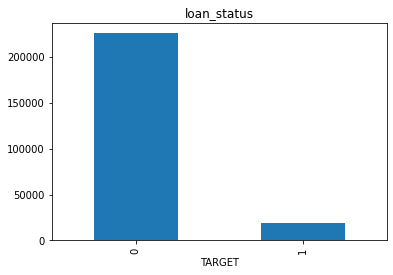

In [21]:
target_saperated = df2.groupby('TARGET')['SK_ID_CURR'].count()
print(target_saperated)
target_saperated.plot.bar(title = "loan_status")

Balance the dataset if the data is imbalanced

In [22]:
df_majority = df2[df2.TARGET==0]
df_minority = df2[df2.TARGET==1]

from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=307511,    # to match majority class
                                 random_state=123)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.TARGET.value_counts()



1    307511
0    226077
Name: TARGET, dtype: int64

Plot the balanced data or imbalanced data

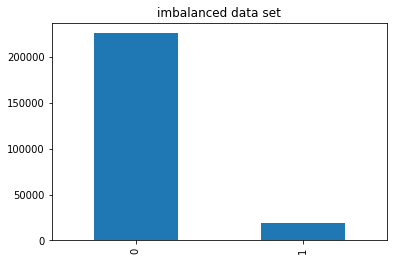

In [23]:
imbalanced= df2['TARGET'].value_counts()
imbalanced.plot.bar(title = "imbalanced data set")

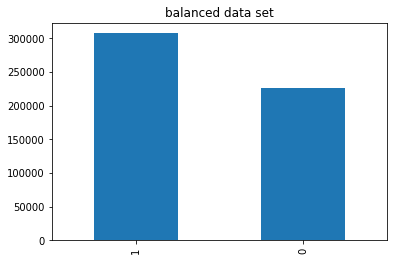

In [24]:
balanced= df_upsampled['TARGET'].value_counts()
balanced.plot.bar(title = "balanced data set")

Split Dataset into train and test

In [28]:
X = df_upsampled.drop('TARGET',axis =1)
y = df_upsampled['TARGET']

x_imbalance = df2.drop('TARGET',axis=1)
y_imbalance = df2['TARGET']

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.33,random_state = 123)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(357503, 76)
(357503,)
(176085, 76)
(176085,)


Encode the columns that is required for the model

In [52]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(x_train)
X_train_enc = oe.transform(x_train)
X_test_enc = oe.fit_transform(x_test)


(357503, 76)
(176085, 76)


In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.fit_transform(y_test)
print(y_train_enc.shape)
print(y_test_enc.shape)

(357503,)
(176085,)


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
logreg = LogisticRegression()

Calculate Sensitivity as a metrice

In [ ]:
model1 = logreg.fit(X_train_enc, y_train_enc)


In [57]:
ytesthat = model1.predict(X_test_enc)
print(X_test_enc.shape)
print(y_test_enc.shape)
print(ytesthat.shape)

(176085, 76)
(176085,)
(176085,)


In [62]:
confusion_matrix = confusion_matrix(y_test_enc,ytesthat)
confusion_matrix

array([[40739, 33810],
       [24527, 77009]])

In [80]:
ns_probs = [0 for _ in range(len(y_test_enc))]

In [61]:
print(confusion_matrix)
print(classification_report(y_test_enc,ytesthat))

<function confusion_matrix at 0x7f733c284d08>
              precision    recall  f1-score   support

           0       0.62      0.55      0.58     74549
           1       0.69      0.76      0.73    101536

    accuracy                           0.67    176085
   macro avg       0.66      0.65      0.65    176085
weighted avg       0.66      0.67      0.66    176085



In [65]:
sensitivity = confusion_matrix[0][0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', sensitivity)

Sensitivity :  0.5464727897087821


Calculate area under receiver operating characteristics curve

In [85]:
# calculate scores
roc = roc_auc_score(y_test_enc,ytesthat)
roc1 = roc_auc_score(y_test_enc,ns_probs)
print("% 3f" %(roc))
print(roc1)

 0.652457
0.5


In [89]:
# calculate roc curves
from sklearn.metrics import roc_curve
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_enc,ytesthat)
ns_fpr, ns_tpr, thresholds = roc_curve(y_test_enc,ns_probs)

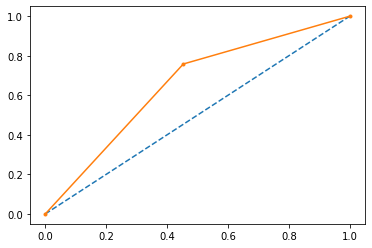

In [91]:
# plot the roc curve for the model
from matplotlib import pyplot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='roc1')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='roc')

Building  Deep learning model prediction

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
# define the model
model = Sequential()
model.add(Dense(60, input_dim= X_train_enc.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(12, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 60)                4620      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                732       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 5,365
Trainable params: 5,365
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])

In [94]:
history = model.fit(X_train_enc, y_train_enc, epochs=40, batch_size=32, validation_data=(X_test_enc, y_test_enc))

Epoch 1/40
11172/11172 [==============================] - 18s 2ms/step - loss: 35.9748 - accuracy: 0.5721 - val_loss: 0.6963 - val_accuracy: 0.5767
Epoch 2/40
11172/11172 [==============================] - 18s 2ms/step - loss: 0.6819 - accuracy: 0.5756 - val_loss: 0.6814 - val_accuracy: 0.5766
Epoch 3/40
11172/11172 [==============================] - 18s 2ms/step - loss: 0.6816 - accuracy: 0.5760 - val_loss: 0.6814 - val_accuracy: 0.5766
Epoch 4/40
11172/11172 [==============================] - 18s 2ms/step - loss: 0.6816 - accuracy: 0.5759 - val_loss: 0.6814 - val_accuracy: 0.5766
Epoch 5/40
11172/11172 [==============================] - 18s 2ms/step - loss: 0.6820 - accuracy: 0.5746 - val_loss: 0.6814 - val_accuracy: 0.5766
Epoch 6/40
11172/11172 [==============================] - 19s 2ms/step - loss: 0.6818 - accuracy: 0.5753 - val_loss: 0.6814 - val_accuracy: 0.5766
Epoch 7/40
11172/11172 [==============================] - 18s 2ms/step - loss: 0.6817 - accuracy: 0.5757 - val_loss: 

In [210]:
train_loss, train_acc = model.evaluate(X_train_enc, y_train_enc, verbose=0)
test_loss, test_acc = model.evaluate(X_test_enc, y_test_enc, verbose=0)

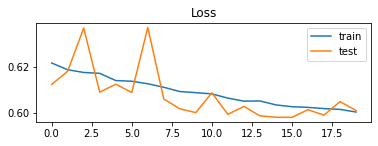

In [200]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

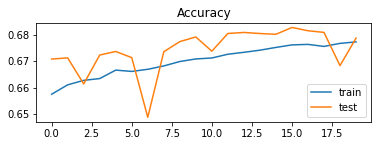

In [201]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [211]:
train_acc

0.6844614148139954